User Segmentation Using RFM and debt/income/credit_score

## Core transforms: group by user and month, compute amount monthly, number transactions, avg 

## Temporal & seasonal features: holidays/blackfriday/ Seasonal index
1. Fourier seasonality (annual): For monthly data (m=12), with order K (e.g., 3–6):
    sin_k(t) = sin(2π k * month_index / 12), cos_k(t) = cos(…).
2. Holiday / event flags (binary):
    US holidays; retail events (Black Friday, Lunar New Year).
3. Seasonal index (per user):
    SI_{u,m} = median(amt) for that user and month m / median(amt) overall for that user.

## Feature at t: SI_{u,month(t)}; at t+1: SI_{u,month(t+1)}.

## Lags: total amt_{t - 1, t - 2, ... t - 12} for every entry point (per user per month), lag of Seasonal index

## Rolling windows: last 3 months total spend, last 6 months total spend

## Expanding window

## Category/mix features



In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
import calendar
import holidays
import warnings


# Load datasets

In [ ]:
df = pd.read_csv(Path.cwd().parent / 'merged-df.csv')
print(f"Loaded dataset with {df.shape[0]:,} rows and {df.shape[1]:,} columns")

Loaded dataset with 13,305,915 rows and 36 columns


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 36 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   transaction_id              int64  
 1   date                        object 
 2   user_id                     int64  
 3   card_id                     int64  
 4   amount                      float64
 5   use_chip                    object 
 6   merchant_id                 int64  
 7   merchant_city               object 
 8   merchant_state              object 
 9   zip                         object 
 10  mcc                         int64  
 11  description                 object 
 12  category                    object 
 13  user_current_age            int64  
 14  user_retirement_age         int64  
 15  user_birth_year             int64  
 16  user_birth_month            int64  
 17  user_gender                 object 
 18  user_address                object 
 19  user_latitude      

In [45]:
per_month_df = pd.read_csv(Path.cwd().parent / 'sequence_no_negative_update.csv')
print(f"Loaded per-month dataset with {per_month_df.shape[0]:,} rows and {per_month_df.shape[1]:,} columns")
per_month_df['year_month'] = pd.to_datetime(per_month_df['year_month']).dt.to_period('M').dt.to_timestamp()

Loaded per-month dataset with 69,814 rows and 29 columns


In [46]:
# === ADD LAG FEATURES TO per_month_df ===
# Compute total spending per user per month from df, then add lag features to per_month_df

# Ensure date columns are datetime
df['date'] = pd.to_datetime(df['date'])
df['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp()

# Compute monthly total spending per user from raw transactions
monthly_spend = (
    df
    .groupby(['user_id', 'year_month'], as_index=False)
    ['amount']
    .sum()
    .rename(columns={'amount': 'total_spending'})
)
monthly_spend = monthly_spend.sort_values(['user_id', 'year_month']).reset_index(drop=True)

# Create lag features (previous month's spending)
monthly_spend['lag_1_spending'] = monthly_spend.groupby('user_id')['total_spending'].shift(1)
monthly_spend['lag_2_spending'] = monthly_spend.groupby('user_id')['total_spending'].shift(2)
monthly_spend['lag_3_spending'] = monthly_spend.groupby('user_id')['total_spending'].shift(3)
monthly_spend['lag_5_spending'] = monthly_spend.groupby('user_id')['total_spending'].shift(5)
monthly_spend['lag_6_spending'] = monthly_spend.groupby('user_id')['total_spending'].shift(6)
monthly_spend['lag_7_spending'] = monthly_spend.groupby('user_id')['total_spending'].shift(7)
monthly_spend['lag_9_spending'] = monthly_spend.groupby('user_id')['total_spending'].shift(9)
monthly_spend['lag_11_spending'] = monthly_spend.groupby('user_id')['total_spending'].shift(11)
monthly_spend['lag_12_spending'] = monthly_spend.groupby('user_id')['total_spending'].shift(12)


# Holidays and events (assumes holidays package available at top-level)
monthly_spend['is_holiday'] = False

yrs = range(monthly_spend['year_month'].dt.year.min(), monthly_spend['year_month'].dt.year.max() + 1)
hols = holidays.CountryHoliday('US', years=yrs)
# For monthly data, mark a month as holiday-month if it contains any holiday
holiday_months = set(pd.to_datetime(list(hols.keys())).to_period('M').to_timestamp())
monthly_spend['is_holiday'] = monthly_spend['year_month'].isin(holiday_months)

# 1-year holiday difference: current spending - spending from same month last year (only for holidays)
monthly_spend['spending_1y_ago'] = monthly_spend.groupby('user_id')['total_spending'].shift(12)
monthly_spend['1y_holiday_diff'] = np.where(
    monthly_spend['is_holiday'],
    monthly_spend['total_spending'] - monthly_spend['spending_1y_ago'],
    np.nan
)
# Drop temporary column
monthly_spend = monthly_spend.drop(columns=['spending_1y_ago'])

In [53]:
# Merge all lag features into per_month_df
lag_cols = ['user_id', 'year_month', 'lag_1_spending', 'lag_2_spending', 'lag_3_spending', 
            'lag_5_spending', 'lag_6_spending', 'lag_7_spending', 
            'lag_9_spending', 'lag_11_spending', 'lag_12_spending', '1y_holiday_diff', 'is_holiday']
per_month_df_with_timeseries = per_month_df.merge(
    monthly_spend[lag_cols], 
    on=['user_id', 'year_month'], 
    how='inner'
)

print(f"\nAdded lag spending features to per_month_df")
print(f"per_month_df_with_timeseries shape: {per_month_df_with_timeseries.shape}")
print(f"\nSample of per_month_df with new lag features:")
display(per_month_df_with_timeseries.head(10))


Added lag spending features to per_month_df
per_month_df_with_timeseries shape: (69814, 40)

Sample of per_month_df with new lag features:


,user_id,year_month,txn_count_prev,total_expense_prev,mean_amount,user_gender,user_current_age,user_yearly_income,user_per_capita_income,user_credit_score,...,lag_2_spending,lag_3_spending,lag_5_spending,lag_6_spending,lag_7_spending,lag_9_spending,lag_11_spending,lag_12_spending,1y_holiday_diff,is_holiday
0,0,2015-01-01,145.0,7517.2,57.9,0,33,59613.0,29237.0,763,...,3859.24,6766.18,4266.63,6777.58,6604.68,5055.62,5109.56,6169.59,-1252.72,True
1,0,2015-02-01,120.0,6364.9,51.8,0,33,59613.0,29237.0,763,...,7091.15,3859.24,5642.49,4266.63,6777.58,7068.70,4600.44,5109.56,-739.90,True
2,0,2015-03-01,97.0,4765.7,54.7,0,33,59613.0,29237.0,763,...,4916.87,7091.15,6766.18,5642.49,4266.63,6604.68,5055.62,4600.44,NaN,False
3,0,2015-04-01,117.0,6130.4,54.1,0,33,59613.0,29237.0,763,...,4369.66,4916.87,3859.24,6766.18,5642.49,6777.58,7068.70,5055.62,NaN,False
4,0,2015-05-01,103.0,5407.5,55.1,0,33,59613.0,29237.0,763,...,5495.42,4369.66,7091.15,3859.24,6766.18,4266.63,6604.68,7068.70,-1420.57,True
5,0,2015-06-01,128.0,6716.1,66.7,0,33,59613.0,29237.0,763,...,4938.54,5495.42,4916.87,7091.15,3859.24,5642.49,6777.58,6604.68,NaN,False
6,0,2015-07-01,120.0,7541.9,61.2,0,33,59613.0,29237.0,763,...,5648.13,4938.54,4369.66,4916.87,7091.15,6766.18,4266.63,6777.58,-1133.53,True
7,0,2015-08-01,99.0,5873.0,49.8,0,33,59613.0,29237.0,763,...,5886.93,5648.13,5495.42,4369.66,4916.87,3859.24,5642.49,4266.63,NaN,False
8,0,2015-09-01,109.0,5283.5,64.9,0,33,59613.0,29237.0,763,...,5644.05,5886.93,4938.54,5495.42,4369.66,7091.15,6766.18,5642.49,67.42,True
9,0,2015-10-01,119.0,7011.9,63.8,0,33,59613.0,29237.0,763,...,5029.51,5644.05,5648.13,4938.54,5495.42,4916.87,3859.24,6766.18,-495.02,True


In [54]:
per_month_df_with_timeseries.to_csv(Path.cwd().parent / 'sequence_with_lag_features.csv', index=False)

# Problem definition — monthly per-customer forecasting

Goal
- Granularity: monthly per customer.
- Series: for each user_id define $amt_t$ = monthly total spend for month t.
- Look-back (LB): 12 months (t-11 … t).
- Target: $y_{t+1} = amt_{t+1}$ (next month).
- Supervised windows: for each user and cut-off t build one training row containing:
  - past-known covariates (lags, rolling windows, expanding stats computed using ≤ t)
  - future-known covariates (calendar/holiday dummies for t+1)
  - label: $amt_{t+1}$
- Data-leakage rule: Every feature for a window ending at month t must use only data ≤ t. Practically: always shift the series (e.g., `.shift(1)` or `.shift(lag)`) before computing rolling/expanding aggregates.



# Core transformations

In [5]:
# Parameters (tweakable)
Q_LOW = 0.01
Q_HIGH = 0.99
REINDEX_GLOBAL_THRESHOLD = 50_000_000  # heuristic: if users * months <= this we will expand globally
REINDEX_GLOBAL = False                 # set True to force global user x month grid (only if you understand memory)
DO_YEO_JOHNSON = False                 # if True, use PowerTransformer(method='yeo-johnson') fitted on train for amt
DO_SIGNED_LOG = True                   # if True (and YE0 not used) use sign(x)*log1p(|x|)
SCALER_TYPE = 'standard'               # options: 'standard', 'robust', 'minmax'
SCALED_FEAT_SUFFIX = '_s'

# Safety checks
required_cols = {'date', 'user_id', 'amount'}
missing = required_cols - set(df.columns)
if missing:
    raise KeyError(f"Missing required columns in df: {missing}")

# 1) monthly aggregation (amt_t, txn_cnt_t, avg_txn_amt_t)
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

count_col = 'transaction_id' if 'transaction_id' in df.columns else None
if count_col:
    monthly = (
        df
        .groupby(['user_id', 'month'], as_index=False)
        .agg(amt_t=('amount', 'sum'), txn_cnt_t=(count_col, 'count'))
    )
else:
    monthly = (
        df
        .groupby(['user_id', 'month'], as_index=False)
        .agg(amt_t=('amount', 'sum'))
    )
    monthly['txn_cnt_t'] = (
        df
        .groupby(['user_id', 'month'])
        .size()
        .values
    )

monthly['avg_txn_amt_t'] = monthly['amt_t'] / monthly['txn_cnt_t'].clip(lower=1)

# 2) reindex to fill missing months per user (choose global or per-user min/max)
all_months = pd.date_range(monthly['month'].min(), monthly['month'].max(), freq='MS')
users = monthly['user_id'].unique()
estimated_rows = len(users) * len(all_months)
print(f"Users: {len(users):,}  Months: {len(all_months):,}  est rows (users x months): {estimated_rows:,}")

if REINDEX_GLOBAL or estimated_rows <= REINDEX_GLOBAL_THRESHOLD:
    # global full reindex (user x full date range)
    print("Performing global user x months reindex (fills every user for every month in the global span).")
    full_index = pd.MultiIndex.from_product([users, all_months], names=['user_id', 'month'])
    monthly = (
        monthly
        .set_index(['user_id', 'month'])
        .reindex(full_index, fill_value=0)
        .reset_index()
    )
else:
    # memory-saving per-user reindex: fill each user's missing months between their min and max month
    print("Large expansion avoided — reindexing each user to their local min/max months (memory-saving). This still fills missing months with zeros.")
    parts = []
    for uid, g in monthly.groupby('user_id'):
        idx = pd.date_range(g['month'].min(), g['month'].max(), freq='MS')
        g2 = (
            g
            .set_index('month')
            .reindex(idx, fill_value=0)
            .rename_axis('month')
            .reset_index()
        )
        g2['user_id'] = uid
        parts.append(g2)
    monthly = pd.concat(parts, ignore_index=True)

# ensure consistent dtypes
monthly = monthly.sort_values(['user_id', 'month']).reset_index(drop=True)
monthly['txn_cnt_t'] = monthly['txn_cnt_t'].fillna(0).astype(int)
monthly['amt_t'] = monthly['amt_t'].fillna(0).astype(float)
monthly['avg_txn_amt_t'] = monthly['avg_txn_amt_t'].fillna(0).astype(float)

print('monthly shape after reindex:', monthly.shape)
display(monthly.head())

# 3) Define time splits used to compute train-only transforms
max_month = monthly['month'].max()
test_start = max_month - pd.DateOffset(months=11)   # last 12 months -> test
val_start = test_start - pd.DateOffset(months=12)   # previous 12 months -> val
print('val_start:', val_start, 'test_start:', test_start)

train_mask = monthly['month'] < val_start
val_mask = (monthly['month'] >= val_start) & (monthly['month'] < test_start)
test_mask = monthly['month'] >= test_start

# 4) Outlier handling (winsorize) — compute thresholds on TRAIN only and apply to all splits
q_low, q_high = Q_LOW, Q_HIGH
train_monthly = monthly[train_mask]
if train_monthly.empty:
    warnings.warn('Training partition is empty — cannot compute train-only winsorization thresholds. Using global quantiles on entire data instead.')
    train_monthly = monthly

# per-user quantiles (train-only). Users without train rows will get filled with global quantiles
global_amt_q_low = train_monthly['amt_t'].quantile(q_low)
global_amt_q_high = train_monthly['amt_t'].quantile(q_high)
user_amt_q = (
    train_monthly
    .groupby('user_id')['amt_t']
    .agg(amt_q01=lambda x: x.quantile(q_low), amt_q99=lambda x: x.quantile(q_high))
)
user_amt_q['amt_q01'] = user_amt_q['amt_q01'].fillna(global_amt_q_low)
user_amt_q['amt_q99'] = user_amt_q['amt_q99'].fillna(global_amt_q_high)

monthly = monthly.merge(user_amt_q[['amt_q01', 'amt_q99']], left_on='user_id', right_index=True, how='left')
monthly['amt_q01'] = monthly['amt_q01'].fillna(global_amt_q_low)
monthly['amt_q99'] = monthly['amt_q99'].fillna(global_amt_q_high)
monthly['amt_t_wins'] = monthly['amt_t'].clip(lower=monthly['amt_q01'], upper=monthly['amt_q99'])

# avg_txn_amt winsorization (same approach)
global_avg_q_low = train_monthly['avg_txn_amt_t'].quantile(q_low)
global_avg_q_high = train_monthly['avg_txn_amt_t'].quantile(q_high)
user_avg_q = (
    train_monthly
    .groupby('user_id')['avg_txn_amt_t']
    .agg(avg_q01=lambda x: x.quantile(q_low), avg_q99=lambda x: x.quantile(q_high))
)
user_avg_q['avg_q01'] = user_avg_q['avg_q01'].fillna(global_avg_q_low)
user_avg_q['avg_q99'] = user_avg_q['avg_q99'].fillna(global_avg_q_high)

monthly = monthly.merge(user_avg_q[['avg_q01', 'avg_q99']], left_on='user_id', right_index=True, how='left')
monthly['avg_q01'] = monthly['avg_q01'].fillna(global_avg_q_low)
monthly['avg_q99'] = monthly['avg_q99'].fillna(global_avg_q_high)
monthly['avg_txn_amt_t_wins'] = monthly['avg_txn_amt_t'].clip(lower=monthly['avg_q01'], upper=monthly['avg_q99'])

# 5) Variance stabilization (optional). Default: sign-preserving log1p. Alternate: Yeo-Johnson fitted on train only.
if DO_YEO_JOHNSON:
    pt = PowerTransformer(method='yeo-johnson')
    # fit on the winsorized training values
    pt.fit(monthly.loc[train_mask, ['amt_t_wins']].values.reshape(-1, 1))
    monthly['amt_t_trans'] = pt.transform(monthly[['amt_t_wins']])
    core_transformers = {'amt_yeo': pt}
else:
    # signed log1p: preserves sign and compresses magnitude, safe for negatives/zeros
    monthly['amt_t_trans'] = np.sign(monthly['amt_t_wins']) * np.log1p(np.abs(monthly['amt_t_wins']))
    core_transformers = {}

# 6) Scaling: fit scaler on TRAIN features only and apply to all data. Keep scaler object for inverse transform.
feature_candidates = ['amt_t_trans', 'txn_cnt_t', 'avg_txn_amt_t_wins']
feature_cols = [c for c in feature_candidates if c in monthly.columns]
print('Feature columns available for scaling:', feature_cols)

scaler_cls = {'standard': StandardScaler, 'robust': RobustScaler, 'minmax': MinMaxScaler}[SCALER_TYPE]
feature_scaler = scaler_cls()
feature_scaler.fit(monthly.loc[train_mask, feature_cols].fillna(0))
scaled_cols = [c + SCALED_FEAT_SUFFIX for c in feature_cols]
monthly[scaled_cols] = feature_scaler.transform(monthly[feature_cols].fillna(0))

# Save artifacts for downstream use (winsorization thresholds, scaler, etc.)
core_transforms = {
    'q_low': q_low,
    'q_high': q_high,
    'global_amt_q': (global_amt_q_low, global_amt_q_high),
    'global_avg_q': (global_avg_q_low, global_avg_q_high),
    'user_amt_q': user_amt_q,           # DataFrame keyed by user_id with amt_q01/amt_q99
    'user_avg_q': user_avg_q,           # DataFrame keyed by user_id with avg_q01/avg_q99
    'feature_scaler': feature_scaler,
    'scaler_features': feature_cols,
    'scaler_suffix': SCALED_FEAT_SUFFIX,
    'transformers': core_transformers,
    'reindex_strategy': 'global' if (REINDEX_GLOBAL or estimated_rows <= REINDEX_GLOBAL_THRESHOLD) else 'per_user_minmax',
    'val_start': val_start,
    'test_start': test_start
}

print('\nCore transforms complete.')
print('monthly (post-core) shape:', monthly.shape)
display(monthly.head())

Users: 1,219  Months: 118  est rows (users x months): 143,842
Performing global user x months reindex (fills every user for every month in the global span).
monthly shape after reindex: (143842, 5)


,user_id,month,amt_t,txn_cnt_t,avg_txn_amt_t
0,0,2010-01-01,4595.38,95,48.372421
1,0,2010-02-01,4960.79,92,53.921630
2,0,2010-03-01,5908.22,105,56.268762
3,0,2010-04-01,5467.19,82,66.673049
4,0,2010-05-01,4626.17,100,46.261700


val_start: 2017-11-01 00:00:00 test_start: 2018-11-01 00:00:00
Feature columns available for scaling: ['amt_t_trans', 'txn_cnt_t', 'avg_txn_amt_t_wins']

Core transforms complete.
monthly (post-core) shape: (143842, 15)
Feature columns available for scaling: ['amt_t_trans', 'txn_cnt_t', 'avg_txn_amt_t_wins']

Core transforms complete.
monthly (post-core) shape: (143842, 15)


,user_id,month,amt_t,txn_cnt_t,avg_txn_amt_t,amt_q01,amt_q99,amt_t_wins,avg_q01,avg_q99,avg_txn_amt_t_wins,amt_t_trans,amt_t_trans_s,txn_cnt_t_s,avg_txn_amt_t_wins_s
0,0,2010-01-01,4595.38,95,48.372421,3712.3791,7904.0426,4595.38,35.228136,66.790537,48.372421,8.433024,0.363846,0.063576,0.275151
1,0,2010-02-01,4960.79,92,53.921630,3712.3791,7904.0426,4960.79,35.228136,66.790537,53.921630,8.509522,0.410554,0.004325,0.528963
2,0,2010-03-01,5908.22,105,56.268762,3712.3791,7904.0426,5908.22,35.228136,66.790537,56.268762,8.684269,0.517250,0.261080,0.636317
3,0,2010-04-01,5467.19,82,66.673049,3712.3791,7904.0426,5467.19,35.228136,66.790537,66.673049,8.606703,0.469890,-0.193179,1.112192
4,0,2010-05-01,4626.17,100,46.261700,3712.3791,7904.0426,4626.17,35.228136,66.790537,46.261700,8.439701,0.367923,0.162328,0.178610


# Temporal & seasonal features

These features are known at forecast time and safe to include as future-known covariates. This cell will add:

- calendar one-hots (month_of_year, quarter),
- Fourier seasonality features (monthly, order K) for both t and t+1,
- holiday / event presence flags (country-specific via python-holidays when available) and a Black Friday detector,
- lead/lag event windows (month-level flags) such as "is_month_before_black_friday" and "is_week_before_black_friday",
- per-user Seasonal Index SI_{u,m} computed on TRAIN only: median(amt) for user & month / median(amt) overall for that user.

All user-level statistics (seasonal index) are computed using the training partition only to avoid leakage. The resulting features are attached for both t and t+1 so they can be joined into supervised windows later.

In [6]:
# Parameters for seasonal features
FOURIER_ORDER = 4  # K: number of harmonics to include
COUNTRY = 'US'     # country code for holidays (holidays import assumed at top)

m = 12  # monthly period

# base calendar features on the month timestamp (start of month)
monthly['month_of_year'] = monthly['month'].dt.month
monthly['quarter'] = monthly['month'].dt.quarter

# one-hot months and quarter (sparse if many users/months)
month_dummies = pd.get_dummies(monthly['month_of_year'].astype(int).astype(str), prefix='mo')
quarter_dummies = pd.get_dummies(monthly['quarter'].astype(int).astype(str), prefix='q')
monthly = pd.concat([monthly, month_dummies, quarter_dummies], axis=1)

# Fourier terms (for month index)
monthly = monthly.reset_index(drop=True)
# Create an integer month index (months since the global minimum month) — robust and avoids using unsupported np.timedelta64('M')
base = monthly['month'].min()
base_idx = base.year * 12 + base.month
monthly['month_index'] = monthly['month'].dt.year * 12 + monthly['month'].dt.month - base_idx
for k in range(1, FOURIER_ORDER + 1):
    monthly[f'sin_{k}'] = np.sin(2 * np.pi * k * monthly['month_index'] / m)
    monthly[f'cos_{k}'] = np.cos(2 * np.pi * k * monthly['month_index'] / m)

# Holidays and events (assumes holidays package available at top-level)
monthly['is_holiday'] = False
monthly['is_black_friday'] = False

yrs = range(monthly['month'].dt.year.min(), monthly['month'].dt.year.max() + 1)
hols = holidays.CountryHoliday(COUNTRY, years=yrs)
# For monthly data, mark a month as holiday-month if it contains any holiday
holiday_months = set(pd.to_datetime(list(hols.keys())).to_period('M').to_timestamp())
monthly['is_holiday'] = monthly['month'].isin(holiday_months)

# Black Friday detection: assume Black Friday = day after US Thanksgiving (4th Thu in Nov)
# Mark the month of Black Friday and a month-before flag to capture pre-event effects

def black_friday_months(year):
    # Thanksgiving: fourth Thursday in November
    nov = calendar.monthcalendar(year, 11)
    # find the Thursday index for the 4th Thursday
    thursdays = [week[calendar.THURSDAY] for week in nov if week[calendar.THURSDAY] != 0]
    if len(thursdays) >= 4:
        thanksgiving_day = thursdays[3]
    else:
        thanksgiving_day = thursdays[-1]
    bf = pd.Timestamp(year=year, month=11, day=thanksgiving_day + 1)
    return bf.to_period('M').to_timestamp()

bf_months = {black_friday_months(y) for y in range(monthly['month'].dt.year.min(), monthly['month'].dt.year.max() + 1)}
monthly['is_black_friday'] = monthly['month'].isin(bf_months)
monthly['is_month_before_black_friday'] = monthly['month'].isin([m_ - pd.DateOffset(months=1) for m_ in bf_months])

# -----------------------------
# Per-user Seasonal Index (SI_{u,m}) — VECTORISED (TRAIN ONLY)
# -----------------------------
train_monthly = monthly[train_mask]

# median per user overall (train only)
user_median_all = train_monthly.groupby('user_id')['amt_t_wins'].median().rename('user_med_all')
# median per user per month-of-year (train only)
user_median_by_month = (
    train_monthly
    .groupby(['user_id', 'month_of_year'])['amt_t_wins']
    .median()
    .rename('user_med_m')
    .reset_index()
)

# merge seasonal index inputs into monthly (vectorized join — avoids apply)
monthly = monthly.merge(user_median_all.reset_index(), on='user_id', how='left')
monthly = monthly.merge(user_median_by_month, on=['user_id', 'month_of_year'], how='left')

# guard against missing medians and zero denominators
monthly['user_med_all'] = monthly['user_med_all'].fillna(0)
monthly['seasonal_index'] = (monthly['user_med_m'] / monthly['user_med_all']).replace([np.inf, -np.inf], np.nan).fillna(1.0)

# attach SI for t+1 (month t+1) using a vectorized join on (user_id, month_tplus1_mo)
monthly['month_tplus1'] = monthly['month'] + pd.DateOffset(months=1)
monthly['month_tplus1_mo'] = monthly['month_tplus1'].dt.month
user_month_map_t1 = user_median_by_month.rename(columns={'month_of_year': 'month_tplus1_mo', 'user_med_m': 'user_med_m_tplus1'})
monthly = monthly.merge(user_month_map_t1[['user_id', 'month_tplus1_mo', 'user_med_m_tplus1']], on=['user_id', 'month_tplus1_mo'], how='left')
monthly['seasonal_index_tplus1'] = (monthly['user_med_m_tplus1'] / monthly['user_med_all']).replace([np.inf, -np.inf], np.nan).fillna(1.0)

# season tag one-hot
monthly['season'] = ((monthly['month_of_year'] % 12 + 3) // 3).map({1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'})
season_dummies = pd.get_dummies(monthly['season'], prefix='sea')
monthly = pd.concat([monthly, season_dummies], axis=1)

print('Temporal & seasonal features added. Columns now:', [c for c in monthly.columns if 'seasonal' in c or c.startswith('mo_') or c.startswith('sin_') or c.startswith('is_')][:40])


Temporal & seasonal features added. Columns now: ['mo_1', 'mo_10', 'mo_11', 'mo_12', 'mo_2', 'mo_3', 'mo_4', 'mo_5', 'mo_6', 'mo_7', 'mo_8', 'mo_9', 'sin_1', 'sin_2', 'sin_3', 'sin_4', 'is_holiday', 'is_black_friday', 'is_month_before_black_friday', 'seasonal_index', 'seasonal_index_tplus1']


In [7]:
monthly[['user_id','month','amt_t_wins','seasonal_index','seasonal_index_tplus1', 'is_black_friday', 'is_holiday']].head(15)

,user_id,month,amt_t_wins,seasonal_index,seasonal_index_tplus1,is_black_friday,is_holiday
0,0,2010-01-01,4595.3800,0.973502,0.947789,False,True
1,0,2010-02-01,4960.7900,0.947789,1.104825,False,True
2,0,2010-03-01,5908.2200,1.104825,1.072287,False,False
3,0,2010-04-01,5467.1900,1.072287,0.903643,False,False
4,0,2010-05-01,4626.1700,0.903643,1.121009,False,True
5,0,2010-06-01,3971.2200,1.121009,1.135784,False,False
6,0,2010-07-01,6079.1400,1.135784,0.990408,False,True
7,0,2010-08-01,4972.5800,0.990408,0.897846,False,False
8,0,2010-09-01,3712.3791,0.897846,1.014535,False,True
9,0,2010-10-01,3943.7600,1.014535,1.021829,False,True


# Lag features (amount & count lags, seasonal lags, seasonal diffs)

This cell computes classic lag features per user using groupby.shift to avoid leakage. By default it will create compact lag set [1,3,6,12] plus seasonal lags (12, 24) and seasonal difference s_diff_12 computed on the winsorized amount (and optionally on log-transformed values).

In [26]:
# === LAG FEATURES ===
# Configurable lag list; default compact set
LAGS = [ 1,2,3,4,6,12, 24, 36]
SEASONAL_LAGS = [12, 24]  # include 24 only when at least 2 years of data per user
USE_COUNT_LAGS = True
COMPUTE_SEASONAL_DIFFS = True

# Ensure monthly is sorted
monthly = monthly.sort_values(['user_id','month']).reset_index(drop=True)

# Amount lags on winsorized amount and transformed amount (amt_t_trans)
for lag in sorted(set(LAGS + SEASONAL_LAGS)):
    monthly[f'lag_amt_{lag}'] = monthly.groupby('user_id')['amt_t_wins'].shift(lag)
    if 'amt_t_trans' in monthly.columns:
        monthly[f'lag_amt_trans_{lag}'] = monthly.groupby('user_id')['amt_t_trans'].shift(lag)

# Count lags
if USE_COUNT_LAGS:
    for lag in LAGS:
        monthly[f'lag_cnt_{lag}'] = monthly.groupby('user_id')['txn_cnt_t'].shift(lag)

# Seasonal differences (amt_t - amt_{t-12}) — also provide on transformed scale if available
if COMPUTE_SEASONAL_DIFFS:
    monthly['s_diff_12'] = monthly['amt_t_wins'] - monthly.groupby('user_id')['amt_t_wins'].shift(12)
    if 'amt_t_trans' in monthly.columns:
        monthly['s_diff_12_trans'] = monthly['amt_t_trans'] - monthly.groupby('user_id')['amt_t_trans'].shift(12)

# Feature width guard: if you want to reduce feature count, we can keep only LAGS + seasonal 12
compact_cols = []
for lag in LAGS:
    compact_cols.append(f'lag_amt_{lag}')
    if 'amt_t_trans' in monthly.columns:
        compact_cols.append(f'lag_amt_trans_{lag}')
    if USE_COUNT_LAGS:
        compact_cols.append(f'lag_cnt_{lag}')
# always include lag_12 for seasonality
compact_cols += [f'lag_amt_12']
if 'amt_t_trans' in monthly.columns:
    compact_cols += [f'lag_amt_trans_12']

print('Created lag columns; sample columns:', [c for c in monthly.columns if c.startswith('lag_')][:30])

Created lag columns; sample columns: ['lag_amt_1', 'lag_amt_trans_1', 'lag_amt_3', 'lag_amt_trans_3', 'lag_amt_6', 'lag_amt_trans_6', 'lag_amt_12', 'lag_amt_trans_12', 'lag_amt_24', 'lag_amt_trans_24', 'lag_cnt_1', 'lag_cnt_3', 'lag_cnt_6', 'lag_cnt_12', 'lag_amt_2', 'lag_amt_trans_2', 'lag_amt_4', 'lag_amt_trans_4', 'lag_amt_36', 'lag_amt_trans_36', 'lag_cnt_2', 'lag_cnt_4', 'lag_cnt_24', 'lag_cnt_36']


In [28]:
display(monthly[["txn_cnt_t", "lag_cnt_1", "lag_cnt_3", "amt_t_trans", "lag_amt_trans_1",  "s_diff_12_trans", ]])

,txn_cnt_t,lag_cnt_1,lag_cnt_3,amt_t_trans,lag_amt_trans_1,s_diff_12_trans
0,95,NaN,NaN,8.433024,NaN,NaN
1,92,95.0,NaN,8.509522,8.433024,NaN
2,105,92.0,NaN,8.684269,8.509522,NaN
3,82,105.0,95.0,8.606703,8.684269,NaN
4,100,82.0,92.0,8.439701,8.606703,NaN
...,...,...,...,...,...,...
143837,31,34.0,42.0,6.434884,6.950882,0.080827
143838,38,31.0,42.0,6.543034,6.434884,-0.114464
143839,34,38.0,34.0,6.550537,6.543034,0.143047
143840,41,34.0,31.0,6.799390,6.550537,0.851303


In [9]:
# === ROLLING & EXPANDING FEATURES ===
# Fixed-width rolling windows (means, sums, stds, cv), momentum, acceleration, z-score, and EWM stats.
# Uses data ≤ t (rolling windows include current row "t").

# Parameters
ROLL_WINDOWS = [3, 6, 12]   # short, medium, long memory
EWM_ALPHAS = [0.5]          # list of alphas for EWM; default 0.5 (fast reaction)
EPS = 1e-8
ROLL_DDF = 0                # ddof for std (0 -> population std, avoids NaN for single obs)
MIN_PERIODS = 1             # allow shorter windows at start

# Ensure sorted
monthly = monthly.sort_values(['user_id', 'month']).reset_index(drop=True)

rolling_cols = []
ewm_cols = []
ewm_std_cols = []

# Rolling stats on winsorized amount
for w in ROLL_WINDOWS:
    roll_mean_col = f'roll_mean_{w}'
    roll_sum_col = f'roll_sum_{w}'
    roll_std_col = f'roll_std_{w}'
    monthly[roll_mean_col] = monthly.groupby('user_id')['amt_t_wins'].transform(lambda x: x.rolling(window=w, min_periods=MIN_PERIODS).mean())
    monthly[roll_sum_col] = monthly.groupby('user_id')['amt_t_wins'].transform(lambda x: x.rolling(window=w, min_periods=MIN_PERIODS).sum())
    # use ddof=0 to avoid NaN for single-value windows
    monthly[roll_std_col] = monthly.groupby('user_id')['amt_t_wins'].transform(lambda x: x.rolling(window=w, min_periods=MIN_PERIODS).std(ddof=ROLL_DDF)).fillna(0)
    monthly[f'roll_cv_{w}'] = monthly[roll_std_col] / (monthly[roll_mean_col] + EPS)

    rolling_cols += [roll_mean_col, roll_sum_col, roll_std_col, f'roll_cv_{w}']

    # also compute on transformed amount if available
    if 'amt_t_trans' in monthly.columns:
        roll_mean_t = f'roll_mean_trans_{w}'
        roll_std_t = f'roll_std_trans_{w}'
        monthly[roll_mean_t] = monthly.groupby('user_id')['amt_t_trans'].transform(lambda x: x.rolling(window=w, min_periods=MIN_PERIODS).mean())
        monthly[roll_std_t] = monthly.groupby('user_id')['amt_t_trans'].transform(lambda x: x.rolling(window=w, min_periods=MIN_PERIODS).std(ddof=ROLL_DDF)).fillna(0)
        monthly[f'roll_cv_trans_{w}'] = monthly[roll_std_t] / (monthly[roll_mean_t].abs() + EPS)
        rolling_cols += [roll_mean_t, roll_std_t, f'roll_cv_trans_{w}']

# Momentum & acceleration
monthly['mom_1'] = monthly['amt_t_wins'] - monthly.groupby('user_id')['amt_t_wins'].shift(1)
monthly['mom_3'] = None
if 3 in ROLL_WINDOWS:
    # mom_3 defined as amt_t - mean(amt_{t-2..t}) --- uses the roll_mean_3 computed above
    monthly['mom_3'] = monthly['amt_t_wins'] - monthly['roll_mean_3']
else:
    monthly['mom_3'] = monthly['amt_t_wins'] - monthly.groupby('user_id')['amt_t_wins'].transform(lambda x: x.rolling(window=3, min_periods=MIN_PERIODS).mean())

# accel = mom_1 - (amt_{t-1} - amt_{t-2})
prev_diff = monthly.groupby('user_id')['amt_t_wins'].shift(1) - monthly.groupby('user_id')['amt_t_wins'].shift(2)
monthly['accel'] = monthly['mom_1'] - prev_diff
rolling_cols += ['mom_1', 'mom_3', 'accel']

# Relative position (z-score)
if 6 in ROLL_WINDOWS:
    monthly['z_6'] = (monthly['amt_t_wins'] - monthly['roll_mean_6']) / (monthly['roll_std_6'] + EPS)
else:
    monthly['z_6'] = (monthly['amt_t_wins'] - monthly.groupby('user_id')['amt_t_wins'].transform(lambda x: x.rolling(window=6, min_periods=MIN_PERIODS).mean())) / (
        monthly.groupby('user_id')['amt_t_wins'].transform(lambda x: x.rolling(window=6, min_periods=MIN_PERIODS).std(ddof=ROLL_DDF)).fillna(0) + EPS
    )
rolling_cols += ['z_6']

# EWM stats (fast-reacting)
ewm_cols = []
ewm_std_cols = []
for alpha in EWM_ALPHAS:
    suffix = f'a{int(alpha*100):02d}'
    ewm_mean_col = f'ewm_mean_{suffix}'
    ewm_std_col = f'ewm_std_{suffix}'
    monthly[ewm_mean_col] = monthly.groupby('user_id')['amt_t_wins'].transform(lambda x: x.ewm(alpha=alpha, adjust=False).mean())
    # ewm.std may produce NaN on first obs; fill with 0
    monthly[ewm_std_col] = monthly.groupby('user_id')['amt_t_wins'].transform(lambda x: x.ewm(alpha=alpha, adjust=False).std()).fillna(0)
    rolling_cols += [ewm_mean_col, ewm_std_col]
    if 'amt_t_trans' in monthly.columns:
        emt = f'ewm_mean_trans_{suffix}'
        est = f'ewm_std_trans_{suffix}'
        monthly[emt] = monthly.groupby('user_id')['amt_t_trans'].transform(lambda x: x.ewm(alpha=alpha, adjust=False).mean())
        monthly[est] = monthly.groupby('user_id')['amt_t_trans'].transform(lambda x: x.ewm(alpha=alpha, adjust=False).std()).fillna(0)
        rolling_cols += [emt, est]

# Expanding stats (optional): expanding mean and count already exist in earlier steps as expanding_mean/expanding_count in supervised builder; include here if needed
monthly['expanding_mean'] = monthly.groupby('user_id')['amt_t_wins'].transform(lambda x: x.expanding(min_periods=1).mean())
monthly['expanding_count'] = monthly.groupby('user_id')['amt_t_wins'].transform(lambda x: x.expanding(min_periods=1).count())
rolling_cols += ['expanding_mean', 'expanding_count']

# Final housekeeping: ensure numeric dtypes and update core_transforms
rolling_cols = [c for c in rolling_cols if c in monthly.columns]
core_transforms['rolling_windows'] = ROLL_WINDOWS
core_transforms['ewm_alphas'] = EWM_ALPHAS
core_transforms['rolling_cols'] = rolling_cols
core_transforms['rolling_eps'] = EPS

print('Added rolling features:', len(rolling_cols), 'columns')
print(rolling_cols[:80])
monthly[['user_id','month','amt_t_wins'] + rolling_cols[:20]].head(10)

Added rolling features: 31 columns
['roll_mean_3', 'roll_sum_3', 'roll_std_3', 'roll_cv_3', 'roll_mean_trans_3', 'roll_std_trans_3', 'roll_cv_trans_3', 'roll_mean_6', 'roll_sum_6', 'roll_std_6', 'roll_cv_6', 'roll_mean_trans_6', 'roll_std_trans_6', 'roll_cv_trans_6', 'roll_mean_12', 'roll_sum_12', 'roll_std_12', 'roll_cv_12', 'roll_mean_trans_12', 'roll_std_trans_12', 'roll_cv_trans_12', 'mom_1', 'mom_3', 'accel', 'z_6', 'ewm_mean_a50', 'ewm_std_a50', 'ewm_mean_trans_a50', 'ewm_std_trans_a50', 'expanding_mean', 'expanding_count']


,user_id,month,amt_t_wins,roll_mean_3,roll_sum_3,roll_std_3,roll_cv_3,roll_mean_trans_3,roll_std_trans_3,roll_cv_trans_3,...,roll_cv_6,roll_mean_trans_6,roll_std_trans_6,roll_cv_trans_6,roll_mean_12,roll_sum_12,roll_std_12,roll_cv_12,roll_mean_trans_12,roll_std_trans_12
0,0,2010-01-01,4595.3800,4595.380000,4595.3800,0.000000,0.000000,8.433024,0.000000,0.000000,...,0.000000,8.433024,0.000000,0.000000,4595.380000,4595.3800,0.000000,0.000000,8.433024,0.000000
1,0,2010-02-01,4960.7900,4778.085000,9556.1700,182.705000,0.038238,8.471273,0.038249,0.004515,...,0.038238,8.471273,0.038249,0.004515,4778.085000,9556.1700,182.705000,0.038238,8.471273,0.038249
2,0,2010-03-01,5908.2200,5154.796667,15464.3900,553.242657,0.107326,8.542272,0.105152,0.012310,...,0.107326,8.542272,0.105152,0.012310,5154.796667,15464.3900,553.242657,0.107326,8.542272,0.105152
3,0,2010-04-01,5467.1900,5445.400000,16336.2000,387.093446,0.071086,8.600165,0.071490,0.008313,...,0.095139,8.558380,0.095242,0.011129,5232.895000,20931.5800,497.851511,0.095139,8.558380,0.095242
4,0,2010-05-01,4626.1700,5333.860000,16001.5800,531.818088,0.099706,8.576891,0.102046,0.011898,...,0.099213,8.534644,0.097521,0.011427,5111.550000,25557.7500,507.132466,0.099213,8.534644,0.097521
5,0,2010-06-01,3971.2200,4688.193333,14064.5800,612.299889,0.130605,8.444495,0.130529,0.015457,...,0.127691,8.493383,0.128209,0.015095,4921.495000,29528.9700,628.429760,0.127691,8.493383,0.128209
6,0,2010-07-01,6079.1400,4892.176667,14676.5300,880.871289,0.180057,8.479855,0.176096,0.020766,...,0.142091,8.540010,0.147238,0.017241,5086.872857,35608.1100,708.946590,0.139368,8.524726,0.141363
7,0,2010-08-01,4972.5800,5007.646667,15022.9400,860.911894,0.171919,8.503920,0.173884,0.020447,...,0.141932,8.540405,0.147159,0.017231,5072.586250,40580.6900,664.235169,0.130946,8.523122,0.132301
8,0,2010-09-01,3712.3791,4921.366367,14764.0991,966.904482,0.196471,8.481459,0.202449,0.023870,...,0.170168,8.462977,0.171328,0.020244,4921.452122,44293.0691,758.233081,0.154067,8.489408,0.157009
9,0,2010-10-01,3943.7600,4209.573033,12628.7191,547.734123,0.130116,8.337245,0.125937,0.015105,...,0.177765,8.408550,0.168877,0.020084,4823.682910,48236.8291,776.823683,0.161044,8.468482,0.161641


# Expanding (cumulative) history features

Compute per-user cumulative statistics up to and including time t (no leakage):

- exp_mean, exp_sum, exp_std (cumulative mean, sum, std)
- seasonal_mean_cum (mean for same month_of_year up to t) and seasonal_ratio = seasonal_mean_cum / exp_mean
- behavioral persistence: nonzero_rate (fraction non-zero months up to t) and run_length_since_zero

These features provide a long-run baseline and capture persistence in behavior.

In [10]:
# === EXPANDING / CUMULATIVE FEATURES ===
# Cumulative (expanding) features per user up to time t.

# Reuse EPS & ROLL_DDF if defined, else fall back
EPS = globals().get('EPS', 1e-8)
ROLL_DDF = globals().get('ROLL_DDF', 0)

# Ensure sorted
monthly = monthly.sort_values(['user_id','month']).reset_index(drop=True)

# Cumulative mean, sum, std
monthly['exp_mean'] = monthly.groupby('user_id')['amt_t_wins'].transform(lambda s: s.expanding(min_periods=1).mean())
monthly['exp_sum'] = monthly.groupby('user_id')['amt_t_wins'].transform(lambda s: s.expanding(min_periods=1).sum())
monthly['exp_std'] = monthly.groupby('user_id')['amt_t_wins'].transform(lambda s: s.expanding(min_periods=1).std(ddof=ROLL_DDF)).fillna(0)

# Seasonal cumulative mean: mean of same month_of_year up to t
monthly['seasonal_mean_cum'] = monthly.groupby(['user_id','month_of_year'])['amt_t_wins'].transform(lambda s: s.expanding(min_periods=1).mean())
monthly['seasonal_ratio'] = monthly['seasonal_mean_cum'] / (monthly['exp_mean'] + EPS)
monthly['seasonal_ratio'] = monthly['seasonal_ratio'].replace([np.inf, -np.inf], np.nan).fillna(1.0)

# Behavioral persistence
monthly['nonzero_cum'] = monthly.groupby('user_id')['amt_t_wins'].transform(lambda s: s.gt(0).expanding(min_periods=1).sum())
monthly['months_seen_cum'] = monthly.groupby('user_id')['amt_t_wins'].transform(lambda s: s.expanding(min_periods=1).count())
monthly['nonzero_rate'] = monthly['nonzero_cum'] / (monthly['months_seen_cum'] + EPS)

# run_length_since_zero: months since last zero-spend month (0 if current month is zero)
def _run_length_since_zero(s):
    zm = s.eq(0)
    gid = zm.cumsum()
    out = gid.groupby(gid).cumcount().astype(int)
    # for pre-zero group (gid == 0) and non-zero values, interpret as months since start
    mask_pre_zero_nonzero = (~zm) & (gid == 0)
    out[mask_pre_zero_nonzero] = out[mask_pre_zero_nonzero] + 1
    out[zm] = 0
    return out

monthly['run_length_since_zero'] = monthly.groupby('user_id')['amt_t_wins'].transform(_run_length_since_zero)

# Housekeeping
exp_cols = ['exp_mean','exp_sum','exp_std','seasonal_mean_cum','seasonal_ratio','nonzero_cum','months_seen_cum','nonzero_rate','run_length_since_zero']
core_transforms['expanding_cols'] = exp_cols

print('Added expanding (cumulative) features:', exp_cols)
monthly[['user_id','month'] + exp_cols].head(12)

Added expanding (cumulative) features: ['exp_mean', 'exp_sum', 'exp_std', 'seasonal_mean_cum', 'seasonal_ratio', 'nonzero_cum', 'months_seen_cum', 'nonzero_rate', 'run_length_since_zero']


,user_id,month,exp_mean,exp_sum,exp_std,seasonal_mean_cum,seasonal_ratio,nonzero_cum,months_seen_cum,nonzero_rate,run_length_since_zero
0,0,2010-01-01,4595.380000,4595.3800,0.000000,4595.3800,1.000000,1.0,1.0,1.0,1
1,0,2010-02-01,4778.085000,9556.1700,182.705000,4960.7900,1.038238,2.0,2.0,1.0,2
2,0,2010-03-01,5154.796667,15464.3900,553.242657,5908.2200,1.146160,3.0,3.0,1.0,3
3,0,2010-04-01,5232.895000,20931.5800,497.851511,5467.1900,1.044773,4.0,4.0,1.0,4
4,0,2010-05-01,5111.550000,25557.7500,507.132466,4626.1700,0.905043,5.0,5.0,1.0,5
5,0,2010-06-01,4921.495000,29528.9700,628.429760,3971.2200,0.806913,6.0,6.0,1.0,6
6,0,2010-07-01,5086.872857,35608.1100,708.946590,6079.1400,1.195064,7.0,7.0,1.0,7
7,0,2010-08-01,5072.586250,40580.6900,664.235169,4972.5800,0.980285,8.0,8.0,1.0,8
8,0,2010-09-01,4921.452122,44293.0691,758.233081,3712.3791,0.754326,9.0,9.0,1.0,9
9,0,2010-10-01,4823.682910,48236.8291,776.823683,3943.7600,0.817583,10.0,10.0,1.0,10


# Category / mix features (top-k shares, trends, entropy, weekend bias)

If a category column exists (e.g., `category`, `mcc`), this cell will:

- pick top-K categories from the TRAIN partition,
- compute per-user-month shares for each top-K category and an 'other' share,
- compute 3-month rolling averages of shares and change vs 12-month average,
- compute category entropy per month (diversity of spending),
- compute weekend_share per month (weekend vs weekday allocation).

This is optional and skipped if no category-like column is found.

In [11]:
# === CATEGORY / MIX FEATURES ===
import re

# Candidate category-like columns in transactions
cat_candidates = ['category', 'mcc', 'merchant_id', 'merchant_city', 'description']
cat_col = next((c for c in cat_candidates if c in df.columns), None)
TOP_K = 5

if cat_col is None:
    print('No category-like column found in transactions; skipping category/mix features.')
else:
    print('Using category column:', cat_col)
    # Use TRAIN transactions to compute global top-K categories to avoid label leakage
    train_tx = df[df['month'] < core_transforms['val_start']]
    topk = train_tx[cat_col].value_counts().nlargest(TOP_K).index.tolist()
    print('Top-k categories (train):', topk)

    # per-user-month category amounts
    cat_monthly = (
        df
        .groupby(['user_id','month', cat_col], as_index=False)
        ['amount']
        .sum()
        .rename(columns={'amount':'amt_cat'})
    )

    # pivot only for top-k categories (others will be aggregated into 'other')
    cat_top = cat_monthly[cat_monthly[cat_col].isin(topk)].copy()
    cat_wide = cat_top.pivot_table(index=['user_id','month'], columns=cat_col, values='amt_cat', aggfunc='sum').fillna(0)
    cat_wide = cat_wide.reset_index()

    # merge top-k amounts into monthly
    monthly = monthly.merge(cat_wide, on=['user_id','month'], how='left')
    # fill NA for top-k columns with 0
    for c in topk:
        if c in monthly.columns:
            monthly[c] = monthly[c].fillna(0)

    # compute other amount as remainder
    top_cols = [c for c in topk if c in monthly.columns]
    monthly['amt_topk_sum'] = monthly[top_cols].sum(axis=1) if top_cols else 0.0
    monthly['amt_other'] = (monthly['amt_t'] - monthly['amt_topk_sum']).clip(lower=0.0)

    # safe denominator
    denom = monthly['amt_t'].clip(lower=EPS)

    # create sanitized share column names
    def _sanitize(x):
        s = re.sub(r'[^0-9a-zA-Z]+', '_', str(x)).lower()
        return s[:40]

    share_cols = []
    for c in top_cols:
        sc = f'share_{_sanitize(c)}'
        monthly[sc] = monthly[c] / denom
        share_cols.append(sc)
        # rolling mean and change vs 12-month average
        monthly[f'{sc}_roll3'] = monthly.groupby('user_id')[sc].transform(lambda s: s.rolling(3, min_periods=1).mean())
        monthly[f'{sc}_chg_vs12'] = monthly[sc] - monthly.groupby('user_id')[sc].transform(lambda s: s.rolling(12, min_periods=1).mean())

    # other share
    monthly['share_other'] = monthly['amt_other'] / denom

    # entropy over top_k + other
    ent_cols = share_cols + ['share_other']
    monthly[ent_cols] = monthly[ent_cols].fillna(0)
    monthly['cat_entropy'] = -(monthly[ent_cols] * np.log(monthly[ent_cols] + EPS)).sum(axis=1)

    # weekend vs weekday bias
    df['is_weekend'] = df['date'].dt.weekday >= 5
    weekend_sum = (
        df[df['is_weekend']]
        .groupby(['user_id','month'], as_index=False)['amount']
        .sum()
        .rename(columns={'amount':'amt_weekend'})
    )
    monthly = monthly.merge(weekend_sum, on=['user_id','month'], how='left')
    monthly['amt_weekend'] = monthly['amt_weekend'].fillna(0)
    monthly['weekend_share'] = monthly['amt_weekend'] / denom

    # housekeeping: collect feature names
    cat_feature_cols = share_cols + [f'{c}_roll3' for c in share_cols] + [f'{c}_chg_vs12' for c in share_cols] + ['share_other','cat_entropy','weekend_share']
    core_transforms['category_topk'] = topk
    core_transforms['category_feature_cols'] = cat_feature_cols

    print('Added category/mix features:', cat_feature_cols)
    monthly[['user_id','month','amt_t'] + cat_feature_cols].head(10)

Using category column: category
Top-k categories (train): ['Food & Dining', 'Transportation & Travel', 'Shopping & Retail', 'Financial & Insurance', 'Home & Utilities']
Top-k categories (train): ['Food & Dining', 'Transportation & Travel', 'Shopping & Retail', 'Financial & Insurance', 'Home & Utilities']


/home/cunbidun/Vi/Columbia University/Capstone/.venv/lib/python3.13/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


Added category/mix features: ['share_food_dining', 'share_transportation_travel', 'share_shopping_retail', 'share_financial_insurance', 'share_home_utilities', 'share_food_dining_roll3', 'share_transportation_travel_roll3', 'share_shopping_retail_roll3', 'share_financial_insurance_roll3', 'share_home_utilities_roll3', 'share_food_dining_chg_vs12', 'share_transportation_travel_chg_vs12', 'share_shopping_retail_chg_vs12', 'share_financial_insurance_chg_vs12', 'share_home_utilities_chg_vs12', 'share_other', 'cat_entropy', 'weekend_share']


# PACF analysis — plan

This section creates plotting utilities and example plots to inspect partial autocorrelation (PACF) of our monthly series.

Defaults and design decisions
- Work on TRAIN partition by default (no leakage): monthly rows where month < val_start.
- Use variance-stabilized series when available (`amt_t_trans`), otherwise `amt_t_wins`.
- Default max lag: 36 months (inspect both short- and annual-seasonal behaviour).
- Only include users with at least a minimum history (default 24 months) when producing pooled per-user summaries.

Cells below implement helper functions (safe PACF computation across users), produce per-user PACF plots for representative users, and build a pooled summary (median PACF + fraction of users with significant PACF at each lag).

In [14]:
# === PACF PLOTTING UTILITIES ===
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf as ts_pacf

# Parameters
PACF_MAX_LAG = 36
MIN_HISTORY_MONTHS = 24
SERIES_COL = 'amt_t_trans' if 'amt_t_trans' in monthly.columns else 'amt_t_wins'

print('Using series for PACF:', SERIES_COL)

# Helper: plot PACF for a single series (pandas Series indexed by month)
def plot_acf_pacf(series, title=None, lags=PACF_MAX_LAG):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    plot_pacf(series.dropna(), ax=ax, lags=lags, alpha=0.05, method='ywm')
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Helper: compute PACF for a series with fallback to tiny sample handling
def compute_pacf(series, nlags=PACF_MAX_LAG):
    s = series.dropna().values
    if len(s) <= 1:
        return np.array([np.nan] * (nlags + 1))
    return ts_pacf(s, nlags=nlags, method='ywm')



Using series for PACF: amt_t_trans


Representative users for PACF plotting: [np.int64(96), np.int64(1684), np.int64(1289)]


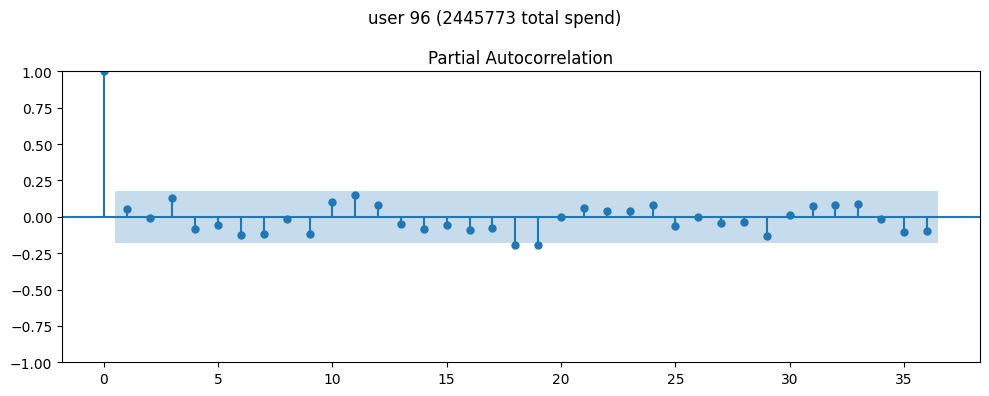

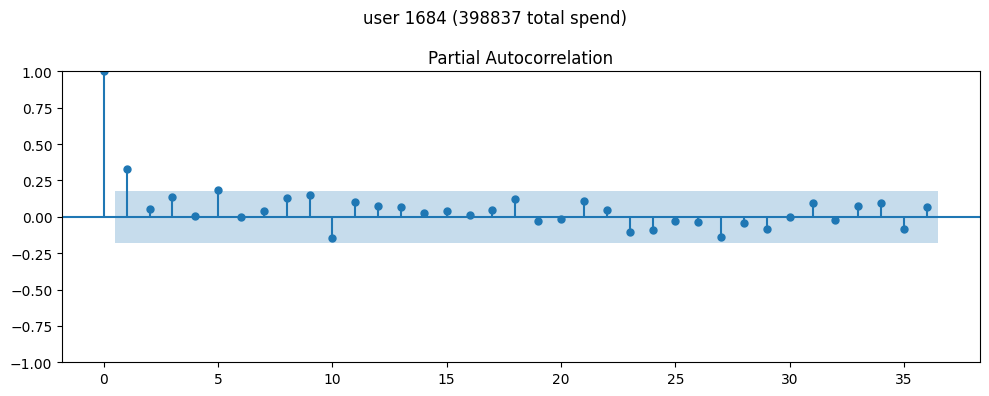

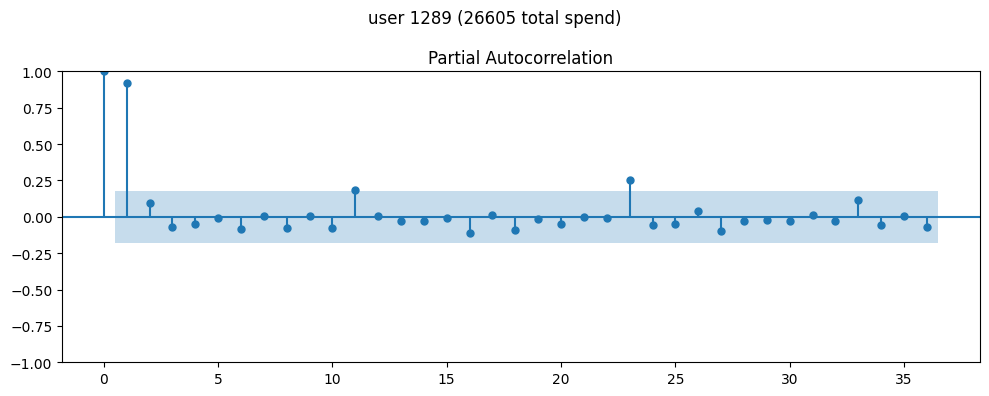

In [15]:
# === PER-USER EXAMPLE PLOTS ===
# Select representative users: top spenders, median spender, low activity
user_month_counts = monthly.groupby('user_id')['amt_t'].count()
user_total_spend = monthly.groupby('user_id')['amt_t'].sum()

# choose three representative users
top_spender = user_total_spend.idxmax()
median_spender = user_total_spend.sort_values().index[len(user_total_spend)//2]
low_spender = user_total_spend.nsmallest(1).index[0]

rep_users = [top_spender, median_spender, low_spender]
print('Representative users for PACF plotting:', rep_users)

for uid in rep_users:
    s = monthly[monthly['user_id'] == uid].set_index('month')[SERIES_COL]
    if s.dropna().shape[0] >= MIN_HISTORY_MONTHS:
        plot_acf_pacf(s, title=f'user {uid} ({int(user_total_spend.loc[uid])} total spend)')
    else:
        print(f'user {uid} has insufficient history ({s.dropna().shape[0]} months) — skipping plot')

,month,total_amt,mean_amt_per_user,median_amt_per_user,pct95_amt,txn_cnt_total,active_users,users_total,avg_per_active_user,pct_users_active,total_amt_trans,lag_12_total_amt,lag_12_total_amt_trans
0,2010-01-01,4372532.12,3586.982871,3128.40,8728.034,101209,1083,1219,4037.425780,0.888433,15.290853,NaN,NaN
1,2010-02-01,4103170.24,3366.013322,2906.18,8018.087,93470,1097,1219,3740.355734,0.899918,15.227271,NaN,NaN
2,2010-03-01,4539853.38,3724.243954,3138.02,8863.128,103345,1097,1219,4138.426053,0.899918,15.328405,NaN,NaN
3,2010-04-01,4407951.33,3616.038827,3076.13,8842.812,100169,1102,1219,3999.955835,0.904020,15.298921,NaN,NaN
4,2010-05-01,4610601.80,3782.282034,3283.35,8852.656,104773,1108,1219,4161.192960,0.908942,15.343869,NaN,NaN


Sanity check: monthly sums match raw transaction aggregation.


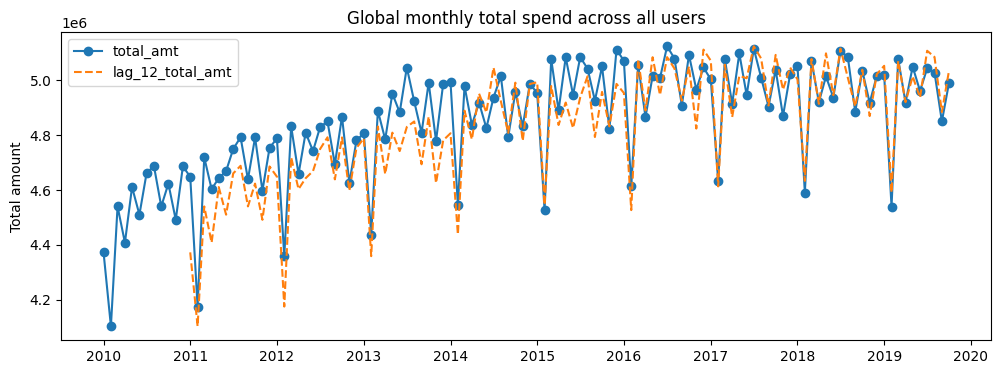

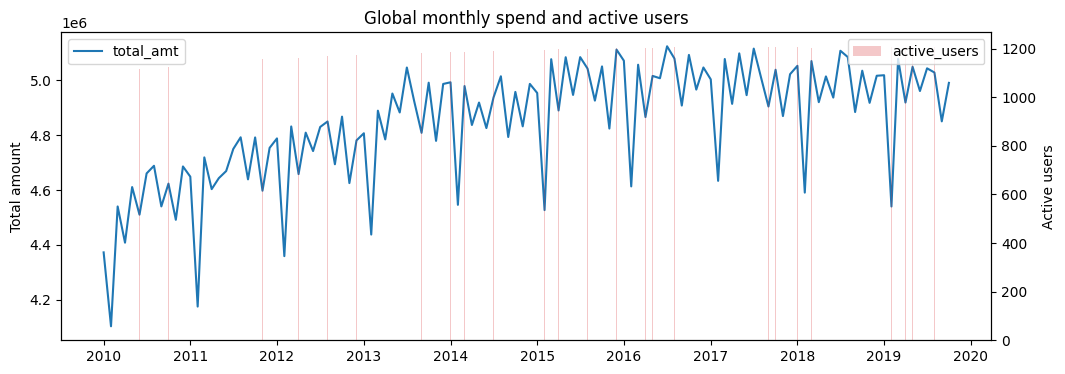

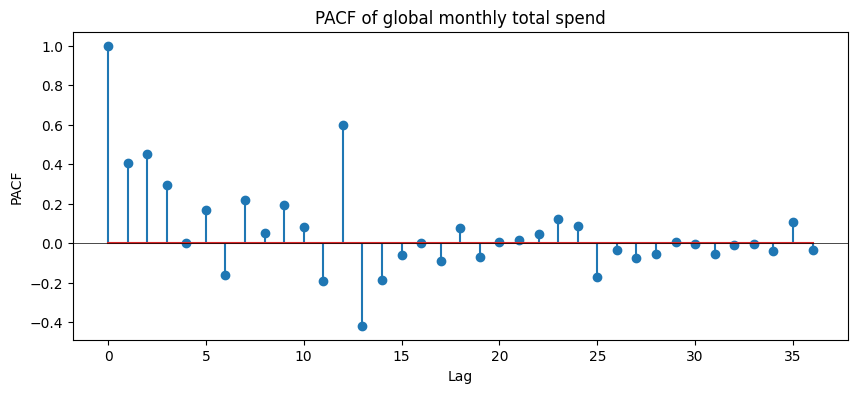

In [18]:
# === GLOBAL (ALL-USERS) MONTHLY AGGREGATES ===
# Compute aggregate time-series across all users (total, per-user stats, active user counts).
# This is useful when you want a single global series rather than per-user series.

global_monthly = (
    monthly
    .groupby('month', as_index=False)
    .agg(
        total_amt=('amt_t', 'sum'),
        mean_amt_per_user=('amt_t', 'mean'),
        median_amt_per_user=('amt_t', 'median'),
        pct95_amt=('amt_t', lambda x: x.quantile(0.95)),
        txn_cnt_total=('txn_cnt_t', 'sum'),
        active_users=('amt_t', lambda x: (x > 0).sum()),
        users_total=('user_id', 'nunique'),
    )
)

# derived ratios
global_monthly['avg_per_active_user'] = global_monthly['total_amt'] / global_monthly['active_users'].replace({0: np.nan})
global_monthly['pct_users_active'] = global_monthly['active_users'] / global_monthly['users_total']

# transform the global total in the same way we treated per-user totals
if DO_YEO_JOHNSON and isinstance(core_transforms.get('transformers', {}).get('amt_yeo', None), PowerTransformer):
    pt = core_transforms['transformers']['amt_yeo']
    global_monthly['total_amt_trans'] = pt.transform(global_monthly[['total_amt']])
else:
    global_monthly['total_amt_trans'] = np.sign(global_monthly['total_amt']) * np.log1p(np.abs(global_monthly['total_amt']))

# simple temporal features on the aggregated series
global_monthly['lag_12_total_amt'] = global_monthly['total_amt'].shift(12)
global_monthly['lag_12_total_amt_trans'] = global_monthly['total_amt_trans'].shift(12)

# show sample
display(global_monthly.head())

# sanity check: compare aggregated totals to raw transaction aggregation
raw_agg = df.groupby('month', as_index=False)['amount'].sum().rename(columns={'amount': 'total_amt_raw'})
global_monthly = global_monthly.merge(raw_agg, on='month', how='left')
if not np.allclose(global_monthly['total_amt'].fillna(0).values, global_monthly['total_amt_raw'].fillna(0).values):
    print('Warning: aggregated totals differ between monthly table and raw transactions (investigate).')
else:
    print('Sanity check: monthly sums match raw transaction aggregation.')

# Quick visualization: total spend and lag-12
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(global_monthly['month'], global_monthly['total_amt'], marker='o', label='total_amt')
ax.plot(global_monthly['month'], global_monthly['lag_12_total_amt'], linestyle='--', label='lag_12_total_amt')
ax.set_ylabel('Total amount')
ax.set_title('Global monthly total spend across all users')
ax.legend()
plt.show()

# Active users overlay (secondary axis)
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
ax1.plot(global_monthly['month'], global_monthly['total_amt'], color='C0', label='total_amt')
ax2 = ax1.twinx()
ax2.bar(global_monthly['month'], global_monthly['active_users'], alpha=0.25, color='C3', label='active_users')
ax1.set_ylabel('Total amount')
ax2.set_ylabel('Active users')
ax1.set_title('Global monthly spend and active users')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

# Optional: PACF for the aggregated series (if PACF utilities are already available in the notebook)
ser = global_monthly.set_index('month')['total_amt_trans']
pacf_vals = compute_pacf(ser, nlags=PACF_MAX_LAG)
plt.figure(figsize=(10, 4))
plt.stem(np.arange(len(pacf_vals)), pacf_vals)
plt.title('PACF of global monthly total spend')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.axhline(0, color='k', lw=0.5)
plt.show()

In [ ]:
Conclusion: meaningful lags: 1,2,3,4,6,12, 24, 36